Author: Patrick Seidel

# Download $NO_2$ Data from Sentinel-5P Tropomi Sensor

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import time
import os

from pathlib import Path
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
)

/opt/homebrew/anaconda3/envs/esdp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Authentication and Config

In [2]:
# Commented out to avoid overwriting existing config
# Comment in to create new config:

# config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
# config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")
config = SHConfig("cdse")

### Evaluation Script

In [3]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["NO2", "dataMask"],
    output: 
      {
        id: "default",
        bands: 1,
        sampleType: "FLOAT32"
      },
    mosaicking: "SIMPLE"
  };
}
function evaluatePixel(sample) {
  if (sample.dataMask == 1)  {
    return [sample.NO2];
  } else {
    return [NaN];
  }
}
"""

### Define Area of Interest and Time Range

In [4]:
# define area of interest
ruhrgebiet_coords_wgs84 = [6.380946, 51.315164, 7.93203, 51.738085]

aoi_bbox = BBox(bbox=ruhrgebiet_coords_wgs84, crs=CRS.WGS84).transform(CRS(3857))

In [5]:
# define time interval
time_range = ("2017-01-01", "2023-12-31")

In [6]:
def download_tropomi_data(
    evalscript: str,
    aoi_bbox,
    time_range,
    freq="D",
    resolution=(1000, 1000),
    save_data=True,
    save_data_folder="./data",
):
    """Download TROPOMI NO2 data from Sentinel-5P using Sentinel Hub.
    Args:
        evalscript (str): The evalscript to use for the request.
        aoi_bbox (BBox): The area of interest bounding box.
        time_range (tuple): A tuple of start and end dates in "YYYY-MM-DD" format.
        freq (str, optional): Frequency for splitting the time range. Defaults to "D" (daily).
        resolution (tuple, optional): Resolution of the output data. Defaults to (1000, 1000).
        save_data (bool, optional): Whether to save the downloaded data. Defaults to True.
        save_data_folder (str, optional): Folder to save the data. Defaults to "./data".
    Returns:
        raw_data_list (list): List of downloaded raw data arrays.
        df_report (pd.DataFrame): DataFrame summarizing the download results.
    """

    start, end = pd.to_datetime(time_range[0]), pd.to_datetime(time_range[1])

    daily_intervals = [
        (
            day.strftime("%Y-%m-%dT00:00:00Z"),
            day.strftime("%Y-%m-%dT23:59:59Z")
        )
        for day in pd.date_range(start, end, freq=freq)
    ]

    raw_data_list = []
    records = []  # rows for the dataframe

    data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

    for i, (t_from, t_to) in enumerate(daily_intervals):

        print(f"Downloading: {t_from} -> {t_to}")

        # Build request
        request_raw = SentinelHubRequest(
            evalscript=evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_5p,
                    time_interval=(t_from, t_to)
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=aoi_bbox,
            resolution=resolution,
            config=config,
            data_folder=os.path.join(save_data_folder, f"{t_from[:10]}"),
        )

        # Execute request with timing + safety
        t0 = time.time()
        try:
            raw = request_raw.get_data(save_data=save_data, redownload=False)
            arr = raw[0]
            success = True
        except Exception as e:
            print("Request failed:", e)
            arr = None
            success = False
        load_time = time.time() - t0

        # Record download result
        if success and arr is not None:
            total_px = arr.size
            valid_px = np.count_nonzero(np.isfinite(arr))
            frac_valid = valid_px / total_px if total_px > 0 else 0.0
            mean_val = np.nanmean(arr) if valid_px > 0 else np.nan
        else:
            total_px = valid_px = 0
            frac_valid = 0.0
            mean_val = np.nan

        # Save raw array
        raw_data_list.append(arr)

        # Append one row to the report
        records.append({
            "date": t_from[:10],
            "success": success,
            "load_time_s": load_time,
            "total_pixels": total_px,
            "valid_pixels": valid_px,
            "fraction_valid": frac_valid,
            "mean_NO2": mean_val,
        })

        print(f"  success={success}, fraction_valid={frac_valid}, mean={mean_val}\n")

    # Build the DataFrame
    df_report = pd.DataFrame(records)

    return raw_data_list, df_report




### Data Load

In [7]:
raw_data_list, df_report = download_tropomi_data(
    evalscript=evalscript_raw,
    aoi_bbox=aoi_bbox,
    time_range=time_range,
    resolution=(5000, 3500),
    save_data_folder="./data/ruhrgebiet",
)

Downloading: 2017-01-01T00:00:00Z -> 2017-01-01T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-02T00:00:00Z -> 2017-01-02T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-03T00:00:00Z -> 2017-01-03T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-04T00:00:00Z -> 2017-01-04T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-05T00:00:00Z -> 2017-01-05T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-06T00:00:00Z -> 2017-01-06T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-07T00:00:00Z -> 2017-01-07T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-08T00:00:00Z -> 2017-01-08T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-09T00:00:00Z -> 2017-01-09T23:59:59Z
  success=True, fraction_valid=0.0, mean=nan

Downloading: 2017-01-10T00:00:00Z -> 2017-01-10T23:59:59Z
  succ

In [8]:
df_report.to_csv("./data/ruhrgebiet/tropomi_no2_report.csv", index=False)

### Plot the results

In [9]:
df_report = pd.read_csv("./data/ruhrgebiet/tropomi_no2_report.csv")

In [10]:
df_report.head()

,date,success,load_time_s,total_pixels,valid_pixels,fraction_valid,mean_NO2
0,2017-01-01,True,0.746003,770,0,0.0,NaN
1,2017-01-02,True,0.258240,770,0,0.0,NaN
2,2017-01-03,True,0.228851,770,0,0.0,NaN
3,2017-01-04,True,0.221370,770,0,0.0,NaN
4,2017-01-05,True,0.298863,770,0,0.0,NaN


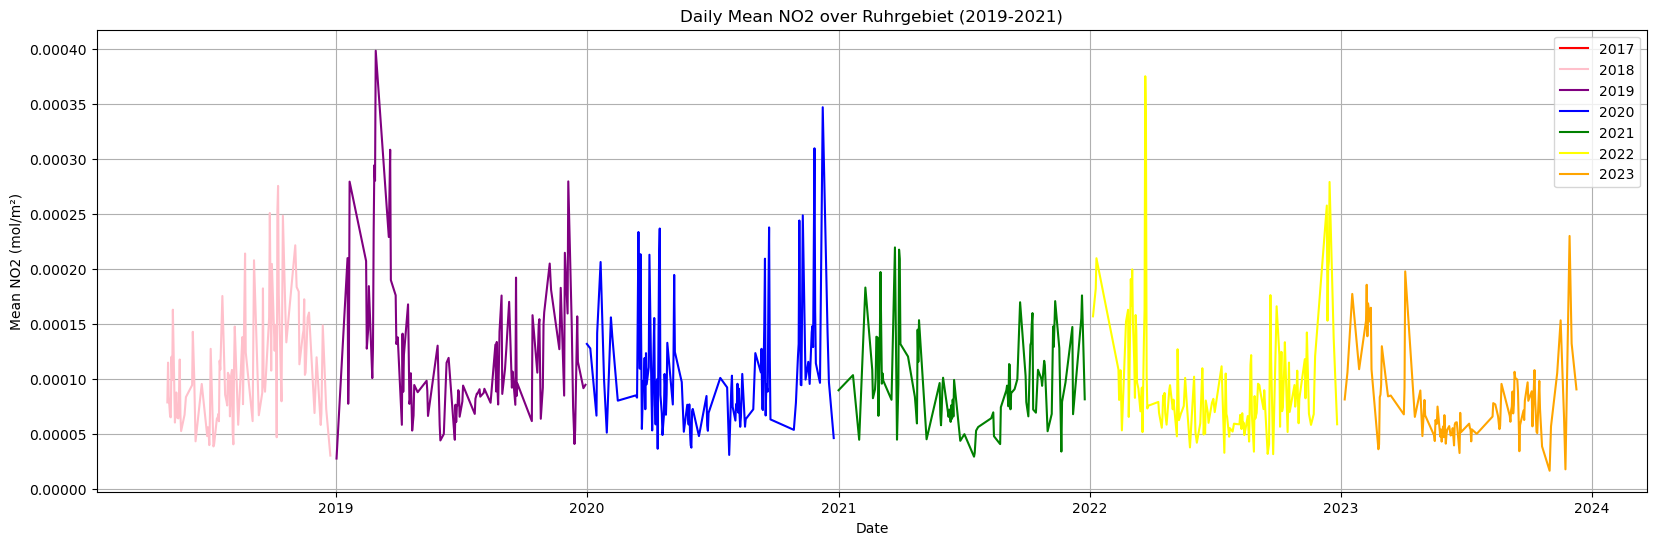

In [ ]:
df_plot = df_report[(df_report["success"] == True) & (df_report["fraction_valid"] > 0.5)]
df_2017 = df_plot[df_plot["date"] < "2018-01-01"]
df_2018 = df_plot[(df_plot["date"] >= "2018-01-01") & (df_plot["date"] < "2019-01-01")]
df_2019 = df_plot[(df_plot["date"] >= "2019-01-01") & (df_plot["date"] < "2020-01-01")]
df_2020 = df_plot[(df_plot["date"] >= "2020-01-01") & (df_plot["date"] < "2021-01-01")]
df_2021 = df_plot[(df_plot["date"] >= "2021-01-01") & (df_plot["date"] < "2022-01-01")]
df_2022 = df_plot[(df_plot["date"] >= "2022-01-01") & (df_plot["date"] < "2023-01-01")]
df_2023 = df_plot[df_plot["date"] >= "2023-01-01"]

# Plot time series of mean NO2 values for each year in a single plot
plt.figure(figsize=(20, 6))
plt.plot(pd.to_datetime(df_2017["date"]), df_2017["mean_NO2"], label="2017", color="red")
plt.plot(pd.to_datetime(df_2018["date"]), df_2018["mean_NO2"], label="2018", color="pink")
plt.plot(pd.to_datetime(df_2019["date"]), df_2019["mean_NO2"], label="2019", color="purple")
plt.plot(pd.to_datetime(df_2020["date"]), df_2020["mean_NO2"], label="2020", color="blue")
plt.plot(pd.to_datetime(df_2021["date"]), df_2021["mean_NO2"], label="2021", color="green")
plt.plot(pd.to_datetime(df_2022["date"]), df_2022["mean_NO2"], label="2022", color="yellow")
plt.plot(pd.to_datetime(df_2023["date"]), df_2023["mean_NO2"], label="2023", color="orange")
plt.xlabel("Date")
plt.ylabel("Mean NO2 (mol/m²)")
plt.title("Daily Mean NO2 over Ruhrgebiet (2019-2021)")
plt.legend()
plt.grid()
plt.show()

from the data we can see that the mission started at the end of 2017 and high quality data (>50% of available pixels) starts not before early 2018

### Convert GeoTiff Data to NetCDF Data

In [12]:
def convert_sentinelhub_output_to_netcdf(
    base_dir,
    output_path,
    attr_dict,
):
    # directories like: data/ruhrgebiet/2021-12-09
    day_dirs = sorted([d for d in Path(base_dir).iterdir() if d.is_dir()])

    tiff_paths = []
    dates = []

    for d in day_dirs:
        try:
            # folder name is the date
            date = pd.to_datetime(d.name)
        except ValueError:
            # skip folders that are not dates
            continue

        # inside: YYYY-MM-DD/<request-id>/response.tiff
        # find all response.tiff files recursively
        tiffs = list(d.rglob("response.tiff"))
        if len(tiffs) == 0:
            continue

        # normally exactly one per day:
        tiff_paths.append(tiffs[0])
        dates.append(date)

    # sort by date
    dates, tiff_paths = zip(*sorted(zip(dates, tiff_paths)))

    # convert tuples to lists
    dates = list(dates)
    tiff_paths = list(tiff_paths)

    data_stack = []
    lat = None
    lon = None

    for i, path in enumerate(tiff_paths):
        with rasterio.open(path) as r:
            arr = r.read(1)

            if lat is None:
                # extract coordinates from geotransform
                height, width = arr.shape
                transform = r.transform

                xs = np.arange(width)
                ys = np.arange(height)

                lon = transform.c + xs * transform.a
                lat = transform.f + ys * transform.e

            data_stack.append(arr)

    data_stack = np.stack(data_stack, axis=0)  # (time, y, x)

    ds = xr.Dataset(
        data_vars={
            "NO2": (("time", "y", "x"), data_stack)
        },
        coords={
            "time": dates,
            "y": lat,
            "x": lon,
        },
        attrs=attr_dict
    )
    ds.to_netcdf(output_path)
    print("Saved:", output_path)

In [13]:
convert_sentinelhub_output_to_netcdf(
    base_dir="./data/ruhrgebiet",
    output_path="no2_ruhrgebiet_daily.nc",
    attr_dict={
        "title": "Daily Sentinel-5P NO2 - Ruhrgebiet",
        "source": "SentinelHub Process API",
        "crs": "EPSG:3857",
        "note": "NaN = no satellite coverage",
    }
)

Saved: no2_ruhrgebiet_daily.nc
